<a href="https://colab.research.google.com/github/r0brt/Daan_Semesterarbeit/blob/master/HaemmerliRobert_Daan_Semesterarbeit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Twitter Data

## Idee
1. Bereingen der Tweeties 
2. 'auto-labeln' mit textblob/Vader.  
3. Anschliessend verschiedene Varianten des Preprocessing (mit/ohne Stemming, Stopwords, ...) ausprobieren.  
4. Ergebnisse - des mit den vorverarbeiteten Texten gefütterten Klassifikators - vergleichen.

### Daten
- tesla-Tweets, download via Twitter-API
- 2586 Zeilen
- Datentyp Text


## 1. Importing Libraries

In [1]:
pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# Generelle Daten-Handling Libraries
import pandas as pd 
pd.options.display.max_colwidth = 144
import numpy as np 
import csv
import string
import re
import json
import time

In [0]:
# Libs Plots und Visualisierungen
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Machine Learning imports
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.externals import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2. Importing & Exploring Data

#### Read csv-File into DataFrame

In [0]:
# read into dataframe from google drive
# dfTweets = pd.read_csv('/content/gdrive/My Drive/data/twitter_sentiment_analysis_train.csv',encoding='iso-8859-1')

In [0]:
# read into dataframe from github
url = 'https://raw.githubusercontent.com/r0brt/Daan_Semesterarbeit/master/twitter_sentiment_analysis_train.csv'
dfTweets = pd.read_csv(url,encoding='iso-8859-1')

#### Shape of the DataFrame

In [9]:
# Number of Rows/Columns
dfTweets.shape

(99989, 3)

-> 99989 Zeilen / 3 Spalten

#### Information about the DataFrame

In [0]:
# Infos über den Dataframe (Spaltennamen, Datentyp, ...)
dfTweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ItemID           99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


#### First view into DataFrame

In [0]:
dfTweets.head(5)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


-> Für diese Arbeit werde ich nur die Spalten 'SentimentText' und 'Sentiment' (als Label) verwenden

#### Check 'Sentiment' for NaN-Values

In [10]:
# NaN-valu#es
print("SentimentText, #NaN: " + str(len(dfTweets) - dfTweets['SentimentText'].count()))

SentimentText, #NaN: 0


-> Spalte 'Sentiment' enthält keine NaN-Values

#### Wieviele hoch ist der Anteil von positiven (1) / negativen (0) Tweets?

In [11]:
# We construct lists with classified tweets:
tweets_pos = [ tweet for index, tweet in enumerate(dfTweets['SentimentText']) if dfTweets['Sentiment'][index] > 0]
tweets_neg = [ tweet for index, tweet in enumerate(dfTweets['SentimentText']) if dfTweets['Sentiment'][index] == 0]
print("Anteil der positiven Tweets: {0:10.1f}%".format(len(tweets_pos)*100/len(dfTweets['SentimentText'])))
print("Anteil der negativen Tweets: {0:10.1f}%".format(len(tweets_neg)*100/len(dfTweets['SentimentText'])))

Anteil der positiven Tweets:       56.5%
Anteil der negativen Tweets:       43.5%


#### Most common words in Twitter-Dataset

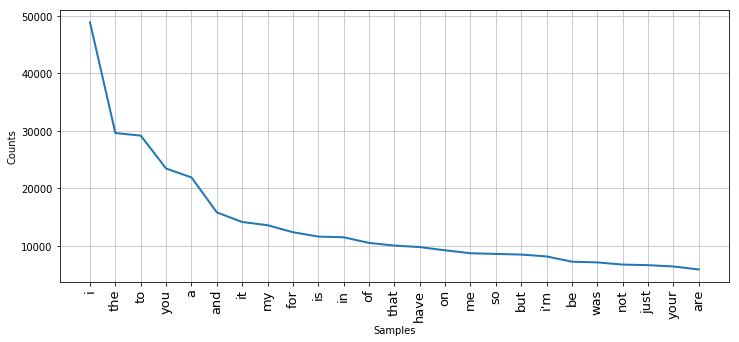

In [0]:
# most common words in twitter dataset
all_words = []
for line in list(dfTweets['SentimentText']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

## 3. Splitting Data

#### Split into Train- & Test-Dataset

In [13]:
from sklearn.model_selection import train_test_split
tweets_train, tweets_test, label_train, label_test = train_test_split(dfTweets['SentimentText'], dfTweets['Sentiment'], test_size=0.2, random_state=79)
print(len(tweets_train), len(tweets_test), len(tweets_train) + len(tweets_test))

79991 19998 99989


## 4. Text Preprocessing

#### Create Helper-Function that:
- Clean Tweets (Remove links / special chars / ...)
- Remove Stopwords
- Lemmatize
- Tokenize

In [0]:
# Bereinigen der Tweets
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
def text_preprocess(tweet):
    '''
    Utility function to
     - clean the text in a tweet by removing links and special characters using regex.
     - tokenize
     - Remove stopwords
     - Lemmatize
    '''
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 1 letters
    tweet = re.sub(r'\b\w{1}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove digits
    tweet = re.sub(r"\d", "", tweet)
    # Remove @-Sign
    tweet = re.sub(r"@", "", tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(tweet) for word in nltk.word_tokenize(sent)]

    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word, pos = 'v') for word in tokens]
    preprocessed_text = ' '.join(tokens)

    return nltk.word_tokenize(preprocessed_text)
    return tweet

In [15]:
# Check to make sure its working
tweets_train.head(3).apply(text_preprocess)

36286                   [uh, kinda, suck, work, tomorrow]
50939               [yay, take, hand, need, update, like]
54441    [absolutely, regret, wonderful, colourful, film]
Name: SentimentText, dtype: object

In [16]:
# Show original dataframe
tweets_train.head()

36286                               @alexavenue Uh you kinda suck, I don't work until tomorrow 
50939                                      @ameeface Yay! Take My Hand needs updating like NOW 
54441    @baiduyou absolutely you should! You won't regret it - a wonderful and colourful film 
52979                                @ayudevina going to bed! take care. . . talk to you later 
93066                                             @ChristaEpiphany oh crap!! I feel sorry 4 u. 
Name: SentimentText, dtype: object

## 5. Vectorization — (Bag Of Words)

#### Fitting CountVectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
# Fitting CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_preprocess).fit(tweets_train)
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

39523


-> Das Vokabular besteht aus ingesamt 39'523 Wörtern

In [0]:
print(bow_transformer.get_feature_names()[5555])
print(bow_transformer.get_feature_names()[6634])

carr
clinch


#### Transform Tweets into bag-of-words corpus

In [0]:
# Transform the entire DataFrame of messages into bag-of-words corpus
messages_bow = bow_transformer.transform(tweets_train)

In [0]:
# Print the shape
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (79991, 39523)
Amount of Non-Zero occurences:  502189


In [19]:
# Print sparsity (ratio null-Values <> total entries)
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity,2)))

sparsity: 0.02


## 6. Term Frequency, Inverse Document Frequency

#### Fitting TfidfTransformer

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
# Fitting TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)

#### Transform bag-of-words corpus  into TF-IDF corpus 

In [21]:
# Transform the entire bag-of-words corpus  into TF-IDF corpus 
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(79991, 39523)


## brauchts glaub nicht: 7. Pipeline Text Preprocssing

In [0]:
from sklearn.pipeline import Pipeline
pipeline_textpreproc = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
])
# pipeline_textpreproc.fit(tweets_test)
# pipeline_textpreproc.transform(tweets_test)
# pipeline_textpreproc.fit_transform(tweets_test)

## 7. Evaluating different Models with Cross-validation

LogReg: 0.743396 (0.004870)
KNN: 0.586754 (0.006307)
DecTree: 0.679126 (0.003947)
RandForr: 0.708742 (0.002535)
NB: 0.726932 (0.006806)


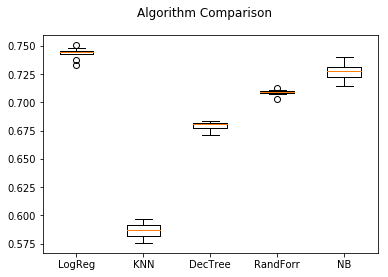

In [0]:
# prepare configuration for cross validation test harness
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
seed = 7

# prepare models
models = []
models.append(('LogReg', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecTree', DecisionTreeClassifier()))
models.append(('RandForr', RandomForestClassifier()))
models.append(('NB', MultinomialNB()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, messages_tfidf, label_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

-> LogisticRegression & MultinomialNB haben die höchste Accuracy und werden weiter verfolgt

## 8. Tuning selected Model with GridSearchCV

#### LogisticRegression - GridSearchCV

In [0]:
# create pipeline for GridSearchCV on LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

pipeline_logr = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),                       # integer counts to weighted TF-IDF scores
    ('logr', LogisticRegression()),                      # train on TF-IDF vectors with LogisticRegression classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {
              'logr__penalty': ['l1', 'l2']
             ,'logr__C': [0.001, 0.01, 0.1, 1, 10, 100]
             }

# do 5-fold cross validation for each of the possible combinations of the above params
grid_logr = GridSearchCV(pipeline_logr, cv=5, param_grid=parameters, verbose=1, n_jobs=6)
grid_logr.fit(tweets_train,label_train)

# summarize results
print("\nBest Model: %f using %s" % (grid_logr.best_score_, grid_logr.best_params_))
print('\n')
means = grid_logr.cv_results_['mean_test_score']
stds = grid_logr.cv_results_['std_test_score']
params = grid_logr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# select best model
model_mnb = grid_logr.best_estimator_
# save best model to a File
joblib.dump(grid_logr.best_estimator_, '/content/gdrive/My Drive/data/TweetsSentiment_logr_clf.pkl', compress = 1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 34.8min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 51.2min finished



Best Model: 0.743321 using {'logr__C': 1, 'logr__penalty': 'l2'}


Mean: 0.565151 Stdev:(0.000015) with: {'logr__C': 0.001, 'logr__penalty': 'l1'}
Mean: 0.565264 Stdev:(0.000085) with: {'logr__C': 0.001, 'logr__penalty': 'l2'}
Mean: 0.613269 Stdev:(0.000854) with: {'logr__C': 0.01, 'logr__penalty': 'l1'}
Mean: 0.661549 Stdev:(0.002578) with: {'logr__C': 0.01, 'logr__penalty': 'l2'}
Mean: 0.709942 Stdev:(0.002065) with: {'logr__C': 0.1, 'logr__penalty': 'l1'}
Mean: 0.730257 Stdev:(0.001463) with: {'logr__C': 0.1, 'logr__penalty': 'l2'}
Mean: 0.741671 Stdev:(0.001523) with: {'logr__C': 1, 'logr__penalty': 'l1'}
Mean: 0.743321 Stdev:(0.001269) with: {'logr__C': 1, 'logr__penalty': 'l2'}
Mean: 0.721306 Stdev:(0.000946) with: {'logr__C': 10, 'logr__penalty': 'l1'}
Mean: 0.728895 Stdev:(0.001278) with: {'logr__C': 10, 'logr__penalty': 'l2'}
Mean: 0.694241 Stdev:(0.002551) with: {'logr__C': 100, 'logr__penalty': 'l1'}
Mean: 0.706329 Stdev:(0.002575) with: {'logr__C': 100, 'logr__penalty': 'l

['/content/gdrive/My Drive/data/TweetsSentiment_logr_clf.pkl']

#### MultinomialNB - GridSearchCV

In [0]:
# create pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

pipeline_mnb = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),                       # integer counts to weighted TF-IDF scores
    ('mnb', MultinomialNB()),                            # train on TF-IDF vectors with NaiveBayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {
               'mnb__fit_prior': [True, False]
              ,'mnb__alpha': [0.01, 0.1, 1, 10]
             }

# do 5-fold cross validation for each of the possible combinations of the above params
grid_mnb = GridSearchCV(pipeline_mnb, cv=5, param_grid=parameters, verbose=1, n_jobs=8)
grid_mnb.fit(tweets_train,label_train)

# summarize results
print("\nBest Model: %f using %s" % (grid_mnb.best_score_, grid_mnb.best_params_))
print('\n')
means = grid_mnb.cv_results_['mean_test_score']
stds = grid_mnb.cv_results_['std_test_score']
params = grid_mnb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

# select best model
model_mnb = grid_mnb.best_estimator_
# save best model to a File
joblib.dump(grid_mnb.best_estimator_, '/content/gdrive/My Drive/data/TweetsSentiment_mnb_clf.pkl', compress = 1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 33.8min finished



Best Model: 0.729445 using {'mnb__alpha': 10, 'mnb__fit_prior': False}


Mean: 0.704954 Stdev:(0.002885) with: {'mnb__alpha': 0.01, 'mnb__fit_prior': True}
Mean: 0.697303 Stdev:(0.002003) with: {'mnb__alpha': 0.01, 'mnb__fit_prior': False}
Mean: 0.711518 Stdev:(0.003045) with: {'mnb__alpha': 0.1, 'mnb__fit_prior': True}
Mean: 0.705379 Stdev:(0.002425) with: {'mnb__alpha': 0.1, 'mnb__fit_prior': False}
Mean: 0.726532 Stdev:(0.003523) with: {'mnb__alpha': 1, 'mnb__fit_prior': True}
Mean: 0.726269 Stdev:(0.002003) with: {'mnb__alpha': 1, 'mnb__fit_prior': False}
Mean: 0.696803 Stdev:(0.003593) with: {'mnb__alpha': 10, 'mnb__fit_prior': True}
Mean: 0.729445 Stdev:(0.001683) with: {'mnb__alpha': 10, 'mnb__fit_prior': False}


['/content/gdrive/My Drive/data/TweetsSentiment_mnb_clf.pkl']

## 9. Final Model Evaluation on Test Data

### LogisticRegression - Evaluating Model

#### accuracy, confusion_matrix & classification_report

In [28]:
from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.externals import joblib
### load from file and predict using the best config found in the CV step
### if needed: 
model_logr = joblib.load('/content/gdrive/My Drive/data/TweetsSentiment_logr_clf.pkl')
print('Model: ')
print(model_logr)
print('\n')
# get predictions from best model above
label_preds = model_logr.predict(tweets_test)
print('\n')      
print('accuracy score: ',round(accuracy_score(label_test, label_preds),3))
print('\n')
print('confusion matrix: \n',confusion_matrix(label_test, label_preds))
print('\n')
print(classification_report(label_test, label_preds))

Model: 
Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_preprocess at 0x7fc0af8cc9d8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])




accuracy score:  0.741


confusion matrix: 
 [[5621 3127]
 [2054 9196]]


              precision    recall  f1-score   support

           0       0.73      0.64      0.68      8748
           1       0.75      0.82      0.78     11250

   micro avg       0.74      0.74      0.74     19998
   macro avg       0.74      0.73      0.73     19998
weighted avg       0.74      0.74      0.74     19998



#### ROC

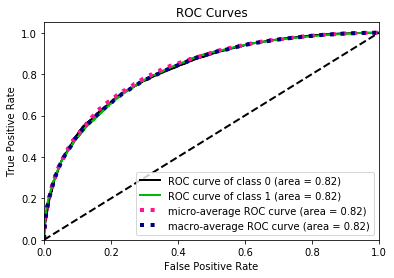

In [31]:
import scikitplot as skplt
# get prediction probabilities
label_preds_proba = model_logr.predict_proba(tweets_test)
# plot ROC-curve
skplt.metrics.plot_roc(label_test, label_preds_proba)
plt.show()

### MultinomialNB - Evaluating Model

#### accuracy, confusion_matrix & classification_report

In [25]:
from sklearn.metrics import  accuracy_score, confusion_matrix, classification_report
from sklearn.externals import joblib
### load from file and predict using the best configs found in the CV step
### if needed: 
model_mnb = joblib.load('/content/gdrive/My Drive/data/TweetsSentiment_mnb_clf.pkl')
print('Model: ')
print(model_mnb)
print('\n')
# get predictions from best model above
label_preds = model_mnb.predict(tweets_test)
print('\n')                    
print('accuracy score: ',round(accuracy_score(label_test, label_preds),3))
print('\n')
print('confusion matrix: \n',confusion_matrix(label_test, label_preds))
print('\n')
print(classification_report(label_test, label_preds))

Model: 
Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_preprocess at 0x7fc0af8cc9d8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor...inear_tf=False, use_idf=True)), ('mnb', MultinomialNB(alpha=10, class_prior=None, fit_prior=False))])




accuracy score:  0.726


confusion matrix: 
 [[5214 3534]
 [1950 9300]]


              precision    recall  f1-score   support

           0       0.73      0.60      0.66      8748
           1       0.72      0.83      0.77     11250

   micro avg       0.73      0.73      0.73     19998
   macro avg       0.73      0.71      0.71     19998
weighted avg       0.73      0.73      0.72     19998



#### ROC

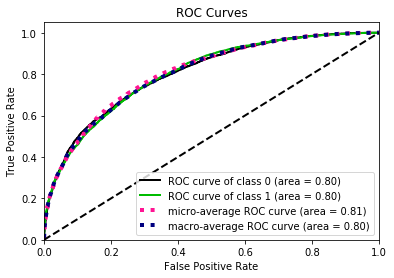

In [32]:
import scikitplot as skplt
# get prediction probabilities
label_preds_proba = model_mnb.predict_proba(tweets_test)
# plot ROC-curve
skplt.metrics.plot_roc(label_test, label_preds_proba)
plt.show()